In [2]:
import importlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import sys
from financial_data import FinDataStruct

%matplotlib inline

In [3]:
in_fp = 'data/raw/kibot/IVE_tickbidask.csv'
out_fp = 'data/clean/IVE_tick.parq'

In [4]:
fin_data = FinDataStruct()

In [5]:
df = fin_data.load_ticks_CSV(in_fp)
df.head()

,price,bid,ask,volume,dollar_volume
timestamp,,,,,
2009-09-28 09:30:00,50.79,50.70,50.79,100,5079.00
2009-09-28 09:30:00,50.71,50.70,50.79,638,32352.98
2009-09-28 09:31:32,50.75,50.75,50.76,100,5075.00
2009-09-28 09:31:33,50.75,50.72,50.75,100,5075.00
2009-09-28 09:31:50,50.75,50.73,50.76,300,15225.00


In [6]:
fin_data.df_to_parquet(df, out_fp)

In [7]:
del df

In [8]:
df = fin_data.parquet_to_df(out_fp)

In [9]:
df.head()

,price,bid,ask,volume,dollar_volume
timestamp,,,,,
2009-09-28 09:30:00,50.79,50.70,50.79,100,5079.00
2009-09-28 09:30:00,50.71,50.70,50.79,638,32352.98
2009-09-28 09:31:32,50.75,50.75,50.76,100,5075.00
2009-09-28 09:31:33,50.75,50.72,50.75,100,5075.00
2009-09-28 09:31:50,50.75,50.73,50.76,300,15225.00


In [10]:
df.describe()

,price,bid,ask,volume,dollar_volume
count,1.618176e+06,1.618176e+06,1.618176e+06,1.618176e+06,1.618176e+06
mean,8.688232e+01,8.686871e+01,8.689108e+01,5.477656e+02,4.807914e+04
std,2.041247e+01,2.041949e+01,2.041296e+01,6.655996e+03,6.693324e+05
min,1.100000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,6.653000e+01,6.652000e+01,6.653000e+01,1.340000e+02,1.139880e+04
50%,9.010000e+01,9.009000e+01,9.011000e+01,2.230000e+02,2.006576e+04
75%,1.050300e+02,1.050200e+02,1.050400e+02,5.000000e+02,4.165700e+04
max,1.211200e+02,1.211200e+02,1.230000e+02,2.600000e+06,2.894918e+08


In [11]:
df = fin_data.remove_outliers(df)
df.describe()

,price,bid,ask,volume,dollar_volume
count,1.618165e+06,1.618165e+06,1.618165e+06,1.618165e+06,1.618165e+06
mean,8.688290e+01,8.686929e+01,8.689135e+01,5.477648e+02,4.807946e+04
std,2.041131e+01,2.041833e+01,2.041278e+01,6.656018e+03,6.693347e+05
min,2.930000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,6.653000e+01,6.652000e+01,6.654000e+01,1.340000e+02,1.139890e+04
50%,9.010000e+01,9.009000e+01,9.011000e+01,2.230000e+02,2.006595e+04
75%,1.050300e+02,1.050200e+02,1.050400e+02,5.000000e+02,4.165710e+04
max,1.211200e+02,1.211200e+02,1.230000e+02,2.600000e+06,2.894918e+08


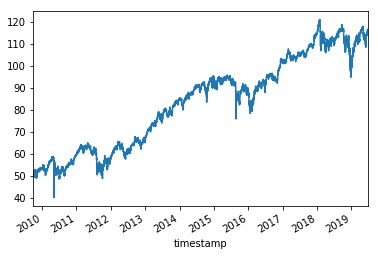

In [12]:
df_tick = fin_data.get_tick_bars(df, 100)
df_tick.price.plot()

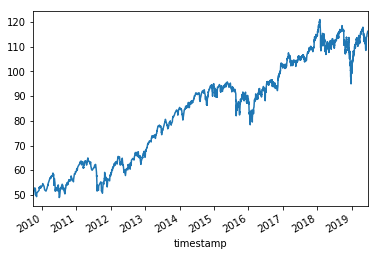

In [13]:
df_vol = fin_data.get_volume_bars(df, 10_000)
df_vol.price.plot()

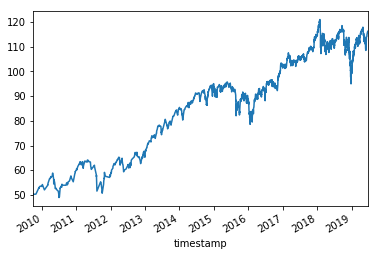

In [14]:
df_dol = fin_data.get_dollar_bars(df, 1_000_000)
df_dol.price.plot()

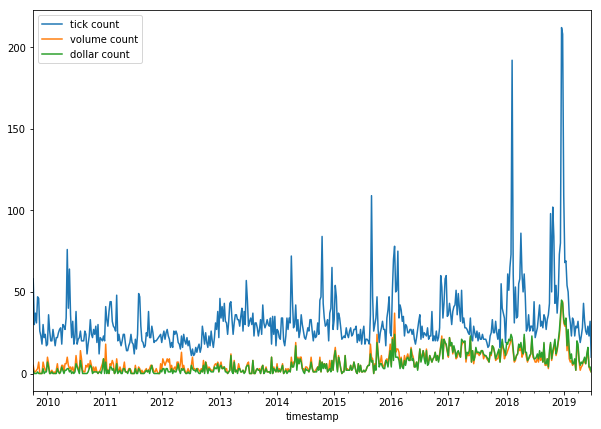

In [15]:
tick_count = df_tick.groupby(pd.Grouper(freq='1W'))['price'].count()
vol_count = df_vol.groupby(pd.Grouper(freq='1W'))['price'].count()
dol_count = df_dol.groupby(pd.Grouper(freq='1W'))['price'].count()

f,ax=plt.subplots(figsize=(10,7))
tick_count.plot(ax=ax, label='tick count')
vol_count.plot(ax=ax, label='volume count')
dol_count.plot(ax=ax, label='dollar count')
ax.legend()

In [16]:
# Calculate Returns
tick_rets = df_tick.price.pct_change().dropna()
vol_rets = df_vol.price.pct_change().dropna()
dol_rets = df_dol.price.pct_change().dropna()

# Serial Correlation/Autocorrelation of returns
names = ['tick', 'vol', 'dol']
autocorr = pd.Series([tick_rets.autocorr(), vol_rets.autocorr(), dol_rets.autocorr()], index=names)
autocorr.abs().sort_values()

vol     0.014507
dol     0.027479
tick    0.044481
dtype: float64

In [17]:
# 1) Monthly subsets of returns
# 2) Calculate variance of returns for each subset
# 3) Calculate variance of those variances
var_of_var = pd.Series([tick_rets.resample('1M').var().var(), vol_rets.resample('1M').var().var(), dol_rets.resample('1M').var().var()], index=names)
var_of_var.abs().sort_values()

tick    1.438976e-09
vol     5.142866e-08
dol     9.341974e-08
dtype: float64

In [18]:
# Jarque-Bera test - Far from zero => not normally distributed
jb_results = pd.Series([stats.jarque_bera(tick_rets)[0], stats.jarque_bera(vol_rets)[0], stats.jarque_bera(dol_rets)[0]], index=names)
jb_results.sort_values()

vol     7.537394e+04
dol     1.025938e+05
tick    5.865300e+07
dtype: float64